In [1]:
from __future__ import print_function

import h5py, os, sys, glob
sys.path.append('../lib')

# to get newer sklearn for updated GradientBoostingRegressor options
# to get newer numpy for numpy.quantile
!pip install scikit-learn==0.20 --user
!pip install numpy==1.15 --user
sys.path.insert(0,'$HOME/.local/lib/python2.7/site-packages/')

import numpy as np

from glob import glob

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from prettytable import PrettyTable

import ROOT as rt

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:12: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/uscms/home/jduarte1/.local/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/uscms/home/jduarte1/.local/lib/python2

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
Mjj_selection = 700.

vae_loss = 'mae'

SM_eff = 1e-2

def computeDiscriminatingVar(x):
    out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
    out *= 1e5
    return out

# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(209109, 13)


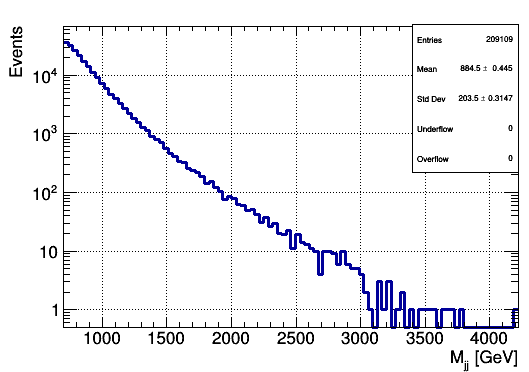

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
print(np.mean(y))

103.62135082607014


In [5]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=10,
                                tol=1e-5,
                                verbose=1)


gbr_cut.fit(x, y)

      Iter       Train Loss   Remaining Time 
         1           0.3888            9.98s
         2           0.3882           10.35s
         3           0.3877           10.27s
         4           0.3873           10.60s
         5           0.3870           12.15s
         6           0.3866           13.37s
         7           0.3864           14.12s
         8           0.3861           14.62s
         9           0.3860           14.98s
        10           0.3858           15.31s
        20           0.3848           12.23s


GradientBoostingRegressor(alpha=0.99, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             n_iter_no_change=10, presort='auto', random_state=None,
             subsample=1.0, tol=1e-05, validation_fraction=0.5, verbose=1,
             warm_start=False)

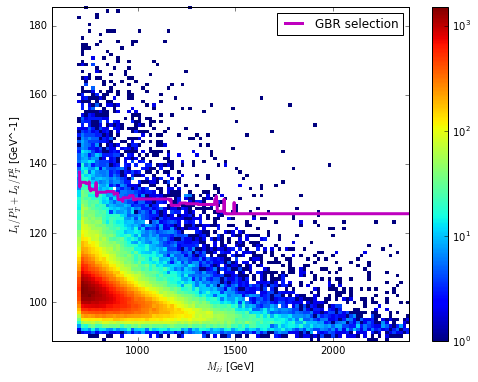

In [6]:
plt.figure(figsize=(8, 6))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-x_min))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [7]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

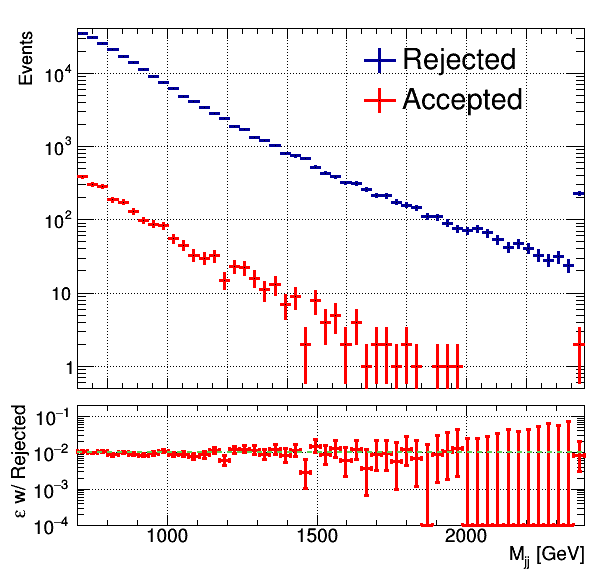

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)
h_a = create_TH1D(x[sel], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt='overflow'
                 )
h_a.SetLineColor(2)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(x[np.logical_not(sel)], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt='overflow'
                 )
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E')
c.pad1.SetLogy()
c.pad2.SetLogy()

c.pad2.cd()
ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
ln.SetLineWidth(2)
ln.SetLineStyle(7)
ln.SetLineColor(8)
ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

c.Draw()

In [9]:
import scipy as sp
def HypotesisTets(h_a, h_r, eff, N_asymov = 100000, show_hist = False):
    aux, _ = rootTH1_to_np(h_r)
    nu = eff*aux/(1-eff)
    
    o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
    
    probs = sp.stats.poisson.pmf(o_asymov, nu)
    nll = -np.log(probs)
    s_asymov = np.sum(nll, axis=-1)
    
    aux, _ = rootTH1_to_np(h_a)
    probs_obs = sp.stats.poisson.pmf(aux.astype(np.int), nu)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    
    p_val = np.sum(s_asymov > s_obs)/float(N_asymov)
    
    
    if show_hist:
        plt.hist(s_asymov)

    return p_val

In [10]:
HypotesisTets(h_a, h_r, SM_eff)

0.8796

# Prepare combine inputs in signal region

### Get the data

In [11]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':'QCD',
                'AtoZZZ':'$A\toZZZ$',
                'GtoWW':'$G\toWW$',
                'GtoBtt':'$G_{B}\tot\bar{t}$',
                'GtoNtt':'$G_{N}\tot\bar{t}$'
               }

BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

In [12]:
data = {}
table = PrettyTable()
table.field_names = ['Sample', 'Tot. evts', 'Sel. evts', 'Eff VAE[%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.3f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], np.sum(data[n]['sel']), eff])
    
print(table)

+--------+-----------+-----------+------------+
| Sample | Tot. evts | Sel. evts | Eff VAE[%] |
+--------+-----------+-----------+------------+
| GtoBtt |   65666   |    9368   |   14.266   |
| GtoWW  |   53630   |   11919   |   22.225   |
| GtoNtt |   64179   |    9312   |   14.509   |
| AtoZZZ |   65148   |   10712   |   16.443   |
|  qcd   |   471448  |    4708   |   0.999    |
+--------+-----------+-----------+------------+


### See the distributions and dump (scaled) histograms into ROOT file

[50, 700.0, 2400.0]

GtoWW
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin0' created with bounds [700,734]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin1' created with bounds [734,768]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin2' created with bounds [768,802]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin3' created with bounds [802,836]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin4' created with bounds [836,870]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin5' created with bounds [870,904]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin6' created with bounds [904,938]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'qcd_bin_tot_x_range_bin7' created with bounds [938,972]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range n

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


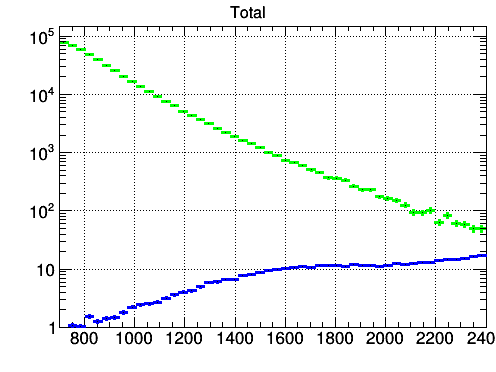

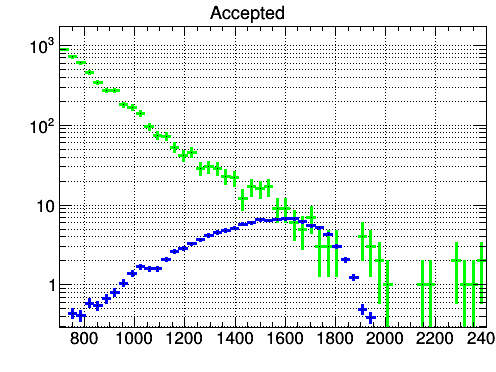

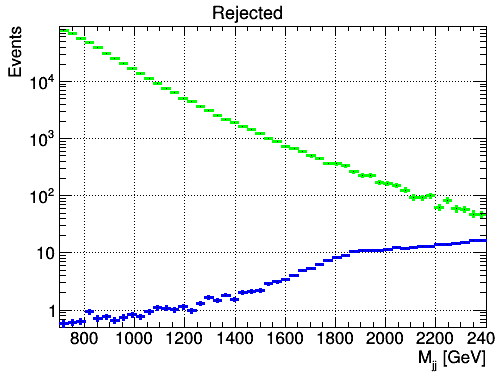

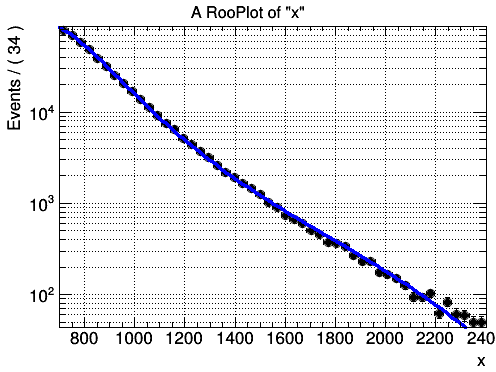

In [13]:
#binning=[50, Mjj_selection, np.quantile(data['qcd']['mJJ'], 0.999)]
binning=[50, Mjj_selection, 2400.0]
print(binning)

# scale factor to scale signal
scale = 0.01

# histogram dictionary
histos = {}

datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',binning[1],binning[2])
w.factory('x[%.1f,%.1f]'%(binning[1],binning[2]))
w.factory('p1[4.1]')
w.factory('p2[7.9]')
w.factory('p3[0.6]')
w.factory('p4[0.025]')
w.factory('sqrts[13000]')
w.factory('qcd_tot_norm[1.]')
w.factory('qcd_bin_tot_norm[1.]')
w.factory("EXPR::qcd_tot('max(0.,pow(1-x/sqrts,p1)/pow(x/sqrts,p2+p3*log(x/sqrts)+p4*log(x/sqrts)*log(x/sqrts)))',x,p1,p2,p3,p4,sqrts)")


w.var('sqrts').setConstant(True)
w.var('p1').setConstant(False)
w.var('p2').setConstant(False)
w.var('p3').setConstant(False)
w.var('p4').setConstant(False)
w.var('qcd_tot_norm').setConstant(False)
w.var('qcd_bin_tot_norm').setConstant(False)
roolist = rt.RooArgList()
roolist.add(w.var('p1'))
roolist.add(w.var('p2'))
roolist.add(w.var('p3'))
roolist.add(w.var('p4'))
roolist.add(w.var('sqrts'))
empty_hist = rt.TH1D('empty_hist','empy_hist',binning[0],binning[1],binning[2])
qcd_bin_tot = rt.RooParametricShapeBinPdf('qcd_bin_tot', 
                                          'qcd_bin_tot', 
                                          w.pdf('qcd_tot'), 
                                          w.var('x'), 
                                          roolist, 
                                          empty_hist)
getattr(w,'import')(qcd_bin_tot, rt.RooCmdArg())

h_t = create_TH1D(data['qcd']['mJJ'], 
                  name='h_tot', title='Total',
                  binning=binning,
                  opt=''
                 )
h_t.SetLineColor(rt.kGreen)
h_t.SetStats(0)
h_t.Sumw2()

w.factory('eqcd_tot_norm[%.1f]'%h_t.Integral())
w.factory("SUM::eqcd_tot(eqcd_tot_norm*qcd_tot)")
w.factory("SUM::eqcd_bin_tot(eqcd_tot_norm*qcd_bin_tot)")
w.var('eqcd_tot_norm').setConstant(False)

h_a = create_TH1D(data['qcd']['mJJ'][data['qcd']['sel']], 
                  name='h_acc', title='Accepted',
                  binning=binning,
                  opt=''
                 )
h_a.SetLineColor(rt.kGreen)
h_a.SetStats(0)
h_a.Sumw2()
h_r = create_TH1D(data['qcd']['mJJ'][np.logical_not(data['qcd']['sel'])], 
                  name='h_rej', title='Rejected',
                  axis_title=['M_{jj} [GeV]', 'Events'],
                  binning=binning,
                  opt=''
                 )
h_r.SetLineColor(rt.kGreen)
h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
h_r.SetStats(0)
h_r.Sumw2()

histos['qcd_tot'] = h_t
histos['qcd_acc'] = h_a
histos['qcd_rej'] = h_r
histos['data_obs_tot'] = h_t
histos['data_obs_acc'] = h_a
histos['data_obs_rej'] = h_r
h_t.SetDirectory(0)
h_a.SetDirectory(0)
h_r.SetDirectory(0)

w.Print('v')

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(h_a.Integral()/h_r.Integral()))
w.var('eff').setConstant(False)
for iBinX in range(1,binning[0]+1):
    w.factory('crBin%i_In[%.1f]'%(iBinX,h_r.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-10,10]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('@0*pow(1.0+%f,@1)',crBin%i_In,crBin%i)"%(iBinX,h_r.GetBinError(iBinX)/h_r.GetBinContent(iBinX),iBinX,iBinX))
    w.factory("expr::bin%iFunc('@0*@1',eff,crBin%i)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('qcd_rph_rej','qcd_rej_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('qcd_rph_rej_norm','qcd_rph_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('qcd_rph_acc','qcd_rph_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('qcd_rph_acc_norm','qcd_rph_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())


for name_BSM in ['GtoWW']:
    print('\n'+name_BSM)
    
    
    h_t_BSM = create_TH1D(data[name_BSM]['mJJ'], 
                  name='h_t'+name_BSM,
                  binning=h_t.binning,
                  opt=''
                 )
    h_t_BSM.SetLineColor(rt.kBlue)
    h_t_BSM.Sumw2()
    h_t_BSM.Scale(scale)
    
    h_a_BSM = create_TH1D(data[name_BSM]['mJJ'][data[name_BSM]['sel']], 
                  name='h_a'+name_BSM,
                  binning=h_a.binning,
                  opt=''
                 )
    h_a_BSM.SetLineColor(rt.kBlue)
    h_a_BSM.Sumw2()
    h_a_BSM.Scale(scale)
    
    h_r_BSM = create_TH1D(data[name_BSM]['mJJ'][np.logical_not(data[name_BSM]['sel'])], 
                  name='h_r'+name_BSM,
                  binning=h_r.binning,
                  opt=''
                 )
    h_r_BSM.SetLineColor(rt.kBlue)
    h_r_BSM.Sumw2()
    h_r_BSM.Scale(scale)

    
    c_t = rt.TCanvas('c_t','c_t',500,400)
    h_t.Draw()
    h_t.SetMinimum(1)
    h_t_BSM.Draw('same')
    c_t.SetLogy()
    c_t.Draw()
    
    c_a = rt.TCanvas('c_a','c_a',500,400)
    h_a.Draw()
    h_a_BSM.Draw('same')
    c_a.SetLogy()
    c_a.Draw()
    
    c_r = rt.TCanvas('c_r','c_r',500,400)
    h_r.Draw()
    h_r_BSM.Draw('same')
    c_r.SetLogy()
    c_r.Draw()
    
    datacard_hist.cd()
    histos[name_BSM+'_tot'] = h_t_BSM
    histos[name_BSM+'_acc'] = h_a_BSM
    histos[name_BSM+'_rej'] = h_r_BSM
    h_t_BSM.SetDirectory(0)
    h_a_BSM.SetDirectory(0)
    h_r_BSM.SetDirectory(0)


for key, histo in histos.iteritems():
    datacard_hist.cd()
    histo.Write(key)
    if 'qcd' not in key:
        ds = rt.RooDataHist(key,key,rt.RooArgList(w.var('x')),histo)
        getattr(w,'import')(ds, rt.RooCmdArg())


nll = w.pdf('eqcd_tot').createNLL(w.data('data_obs_tot'))
m2 = rt.RooMinimizer(nll)
m2.setStrategy(2)
m2.setMaxFunctionCalls(100000)
m2.setMaxIterations(100000)
m2.setPrintLevel(-1)
m2.setPrintEvalErrors(-1)
m2.setEps(1e-5)
m2.optimizeConst(2)
migrad_status = m2.minimize('Minuit2', 'migrad')
improve_status = m2.minimize('Minuit2', 'improve')
hesse_status = m2.minimize('Minuit2', 'hesse')
fr = m2.save()

fr.Print('v')

datacard_ws.cd()
w.Write()
datacard_hist.Close()
datacard_ws.Close()


c_frame = rt.TCanvas('c_frame','c_frame',500,400)
frame = w.var('x').frame()
w.data('data_obs_tot').plotOn(frame)
w.pdf('eqcd_tot').plotOn(frame)
frame.Draw()
c_frame.Draw()
c_frame.SetLogy()

w.Print('v')

## Define datacard based on histogram template fit

In [14]:
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

datacard_ws = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       -
qcd_{BIN}_norm   flatParam
p1   flatParam
p2   flatParam
p3   flatParam
p4   flatParam
'''



datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd_rph
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       -
eff   flatParam
'''

In [15]:
datacard_tot = datacard.format(BIN='tot',
                          OBS=h_t.Integral(),
                          QCDRATE=h_t.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_t_BSM.Integral())
print(datacard_tot)
with open('datacard_tot.txt','w') as f:
    f.write(datacard_tot)
    
datacard_acc = datacard.format(BIN='acc',
                          OBS=h_a.Integral(),
                          QCDRATE=h_a.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_a_BSM.Integral())
print(datacard_acc)
with open('datacard_acc.txt','w') as f:
    f.write(datacard_acc)
    
    
datacard_ws_tot = datacard_ws.format(BIN='tot',
                          OBS=h_t.Integral(),
                          QCDRATE=h_t.Integral(),
                          BSM=name_BSM,
                          BSMRATE=h_t_BSM.Integral())
print(datacard_ws_tot)
with open('datacard_ws_tot.txt','w') as f:
    f.write(datacard_ws_tot)
    
    
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=h_a.Integral(),
                          QCDRATE=1,
                          BSM=name_BSM,
                          BSMRATE=h_a_BSM.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=h_r.Integral(),
                          QCDRATE=1,
                          BSM=name_BSM,
                          BSMRATE=h_r_BSM.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin tot
observation 471023.0
------------------------------
bin             tot      tot
process         GtoWW     qcd
process         0          1
rate            410.91    471023.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 4704.0
------------------------------
bin             acc      acc
process         GtoWW     qcd
process         0          1
rate            118.88    4704.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin 

# Run combine

In [16]:
# using "total" region
!combine -M AsymptoticLimits -d datacard_tot.txt -t -1 --toysFreq

 <<< Combine >>> 
>>> method used is AsymptoticLimits
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: GtoWW
Bin        Contents        Error           Notes                         
0          78425.820000    280.044654      total sum                     
0          78425.000000    280.044639      excluding marked processes    
0          78425.000000    280.044639      Unweighted events, alpha=1.000010
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          69473.060000    263.575436      total sum                     
1          69472.000000    263.575416      excluding marked processes    
1          69472.000000    263.575416      Unweighted events, alpha=1.000015
  => Total parameter prop_bintot_bin1[0.00,-7.0


 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 0.4642
Expected  2.5%: r < 0.2477
Expected 16.0%: r < 0.3318
Expected 50.0%: r < 0.4629
Expected 84.0%: r < 0.6548
Expected 97.5%: r < 0.8930

Done in 0.02 min (cpu), 0.02 min (real)


In [17]:
# using "accept" signal region
!combine -M AsymptoticLimits -d datacard_acc.txt -t -1 --toysFreq

 <<< Combine >>> 
>>> method used is AsymptoticLimits
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: GtoWW
Bin        Contents        Error           Notes                         
0          895.240000      29.916591       total sum                     
0          895.000000      29.916551       excluding marked processes    
0          895.000000      29.916551       Unweighted events, alpha=1.000268
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          722.440000      26.870140       total sum                     
1          722.000000      26.870058       excluding marked processes    
1          722.000000      26.870058       Unweighted events, alpha=1.000609
  => Total parameter prop_binacc_bin1[0.00,-7.0


 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 0.2554
Expected  2.5%: r < 0.1039
Expected 16.0%: r < 0.1597
Expected 50.0%: r < 0.2559
Expected 84.0%: r < 0.3997
Expected 97.5%: r < 0.5844

Done in 0.01 min (cpu), 0.01 min (real)


In [18]:
# using "total" region with dijet fit
!combine -M AsymptoticLimits -d datacard_ws_tot.txt -t -1 --toysFreq

 <<< Combine >>> 
>>> method used is AsymptoticLimits
>>> random number generator seed is 123456

 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 0.3513

Done in 0.01 min (cpu), 0.01 min (real)


In [19]:
!combine -M FitDiagnostics  -d datacard_ratio_rej.txt -v 2


>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Creating pdfs for individual modes (1): .   done.
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin26Func is duplicated
Object crBin27Func is d


  RooFitResult: minimized FCN value: -15.7495, estimated distance to minimum: 1.1831e-05
                covariance matrix quality: Full matrix, but forced positive-definite
                Status : MINIMIZE=1 HESSE=1 

    Constant Parameter    Value     
  --------------------  ------------
            crBin10_In    1.3548e+04
            crBin11_In    1.1113e+04
            crBin12_In    9.2040e+03
            crBin13_In    7.4630e+03
            crBin14_In    6.3750e+03
            crBin15_In    5.1050e+03
            crBin16_In    4.3680e+03
            crBin17_In    3.7150e+03
            crBin18_In    3.1630e+03
            crBin19_In    2.5640e+03
             crBin1_In    7.7530e+04
            crBin20_In    2.1850e+03
            crBin21_In    1.8970e+03
            crBin22_In    1.6250e+03
            crBin23_In    1.4360e+03
            crBin24_In    1.2260e+03
            crBin25_In    1.0050e+03
            crBin26_In    8.8300e+02
            crBin27_In    7.3100e+02
  

Done in 0.01 min (cpu), 0.02 min (real)
Printing Message Summary From ... combine_logger.out
----------------------------------------------
Messages of type INFO : 10
Messages of type DEBUG : 3
Messages of type ERROR : 1
----------------------------------------------
INFO: (function: improveOnce) CascadeMinimizer.cc: 167 -- Minimisation configured with Type=Minuit2, Algo=Migrad, strategy=1, tolerance=0.1
INFO: (function: improveOnce) CascadeMinimizer.cc: 190 -- Minimisation finished with status=0
INFO: (function: improveOnce) CascadeMinimizer.cc: 195 -- Minimization success! status=0
INFO: (function: improveOnce) CascadeMinimizer.cc: 167 -- Minimisation configured with Type=Minuit2, Algo=Migrad, strategy=1, tolerance=0.1
INFO: (function: improveOnce) CascadeMinimizer.cc: 190 -- Minimisation finished with status=0
INFO: (function: improveOnce) CascadeMinimizer.cc: 195 -- Minimization success! status=0
DEBUG: (function: runSpecific) FitDiagnostics.cc: 305 -- Fit B-only, status = 0, numBa